In [2]:
import pandas as pd
import numpy as np


In [5]:
import os

folder_path = '/home/kas/Projects/accelerate_data_process/data example small/Analysis_results-ascii/MS(t)_averaged/'  # ← update this to your folder
dfs = []

for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path, sep='\t')  # adjust header/sep as needed
        df['source_file'] = filename  # optional: track origin
        dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)


In [6]:
df_all.columns

Index(['Time(s)', 'MZ1(Torr)', 'Std1(Torr)', 'MZ2(Torr)', 'Std2(Torr)',
       'MZ3(Torr)', 'Std3(Torr)', 'MZ4(Torr)', 'Std4(Torr)', 'MZ5(Torr)',
       ...
       'Std196(Torr)', 'MZ197(Torr)', 'Std197(Torr)', 'MZ198(Torr)',
       'Std198(Torr)', 'MZ199(Torr)', 'Std199(Torr)', 'MZ200(Torr)',
       'Std200(Torr)', 'source_file'],
      dtype='object', length=402)

In [15]:
valid_i = set()

for df in dfs:
    for col in df.columns:
        if col.startswith("MZ"):
            #print(df[col].max())
            i = int(col[2:-6])  # extract the number after "MZ"
            if df[col].max() > 1e-9:
                valid_i.add(i)
            
valid_i = sorted(valid_i)
print("Indices where max(MZ{i}) > 1e-9:", valid_i)

Indices where max(MZ{i}) > 1e-9: [2, 28, 44]


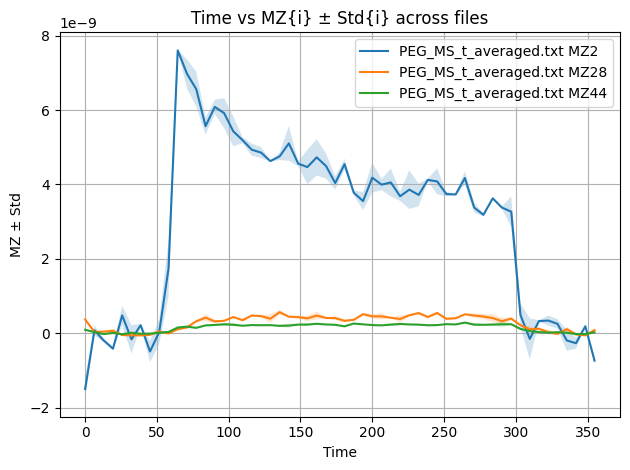

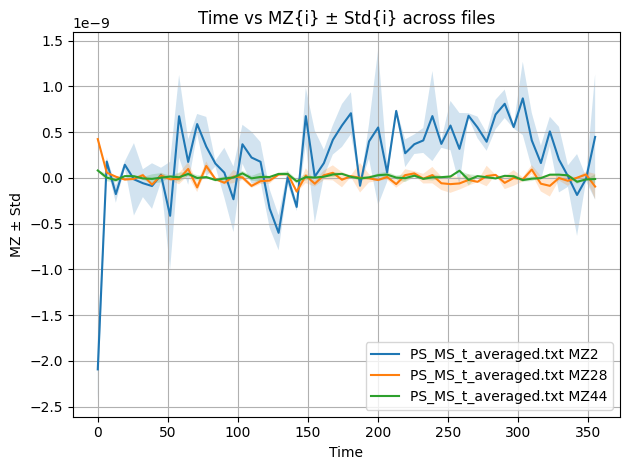

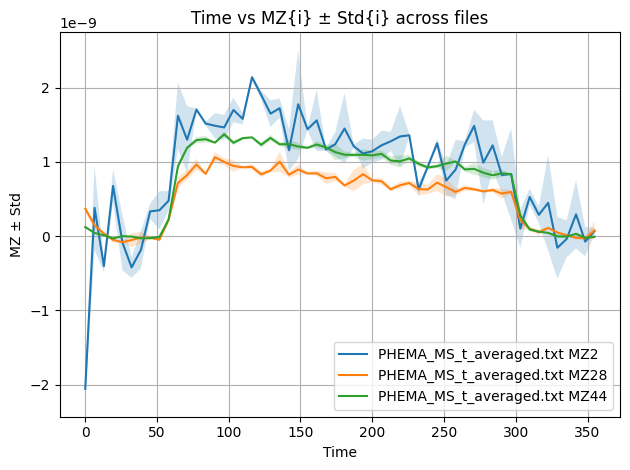

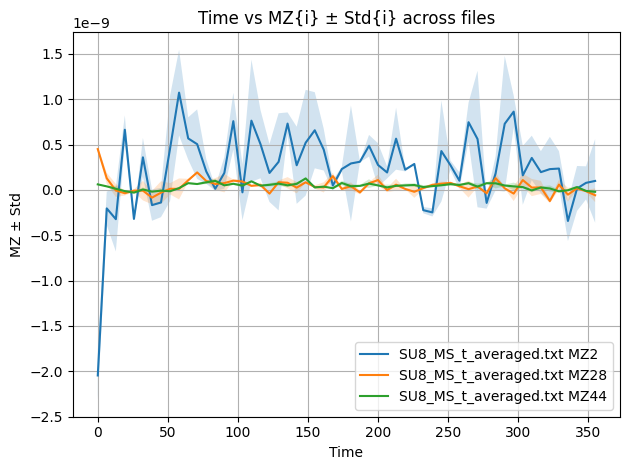

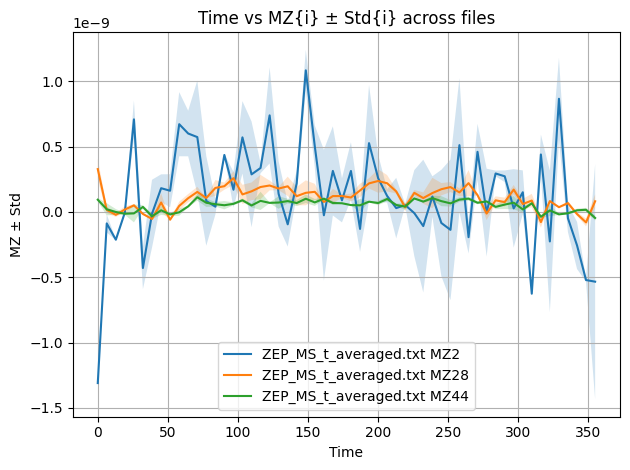

In [29]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(10, 6))

for df in dfs:
    label = df['source_file'].iloc[0] if 'source_file' in df.columns else 'Unnamed'
    
    for i in [2, 28, 44]:  # adjust range based on how many MZ{i} columns you have
        mz_col = f"MZ{i}(Torr)"
        std_col = f"Std{i}(Torr)"
        if mz_col in df.columns and std_col in df.columns:
            plt.plot(df['Time(s)'], df[mz_col], label=f"{label} MZ{i}")
            plt.fill_between(df['Time(s)'], df[mz_col] - df[std_col], df[mz_col] + df[std_col], alpha=0.2)

    plt.xlabel("Time")
    plt.ylabel("MZ ± Std")
    plt.title("Time vs MZ{i} ± Std{i} across files")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


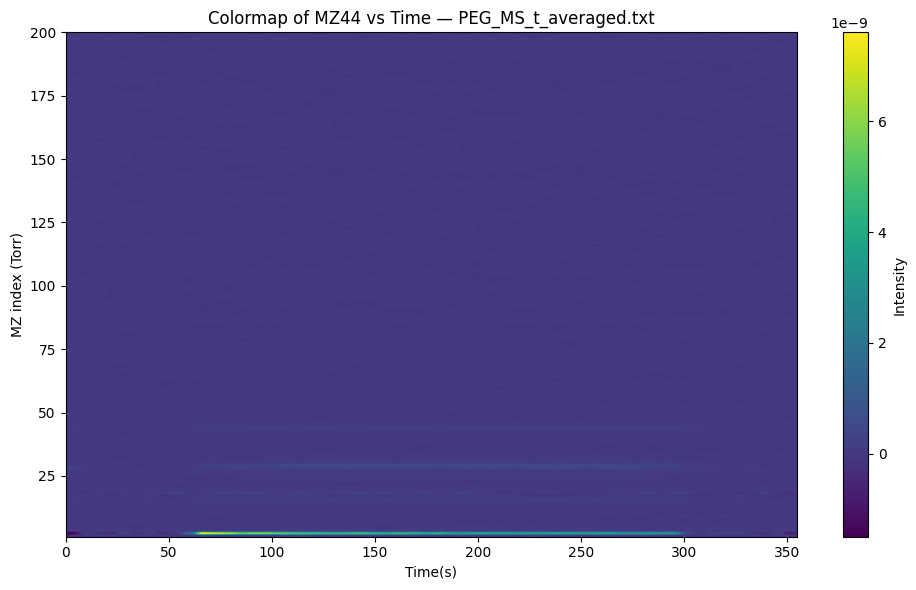

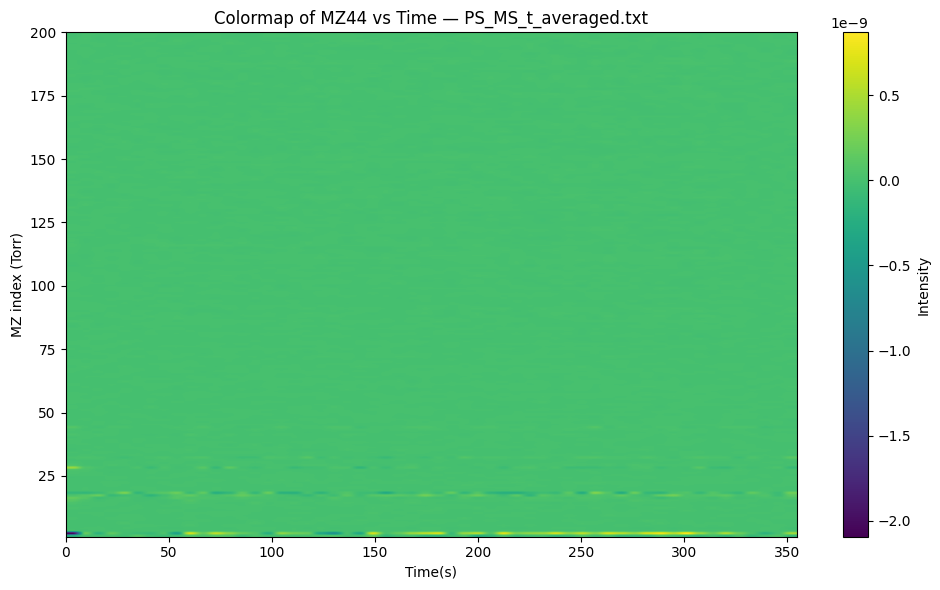

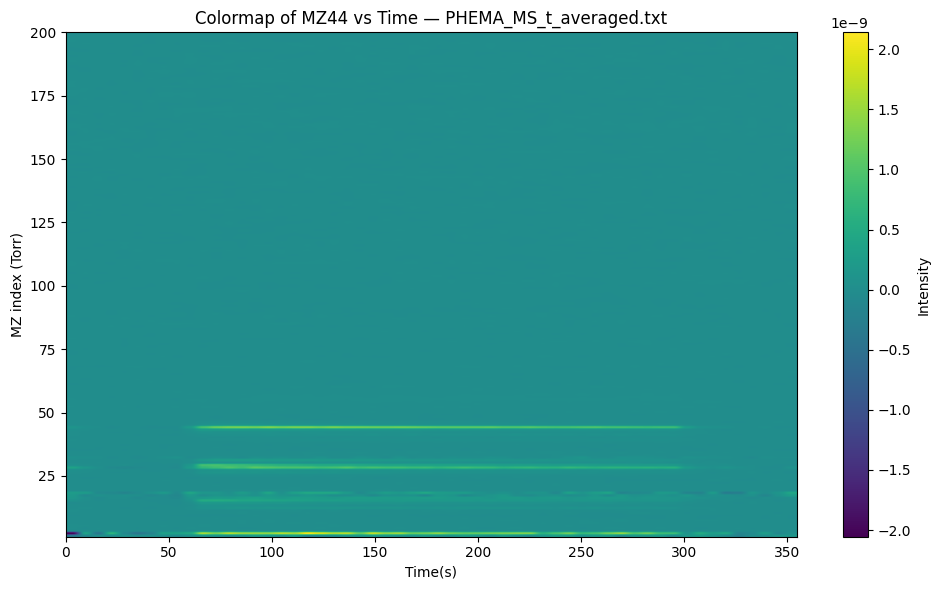

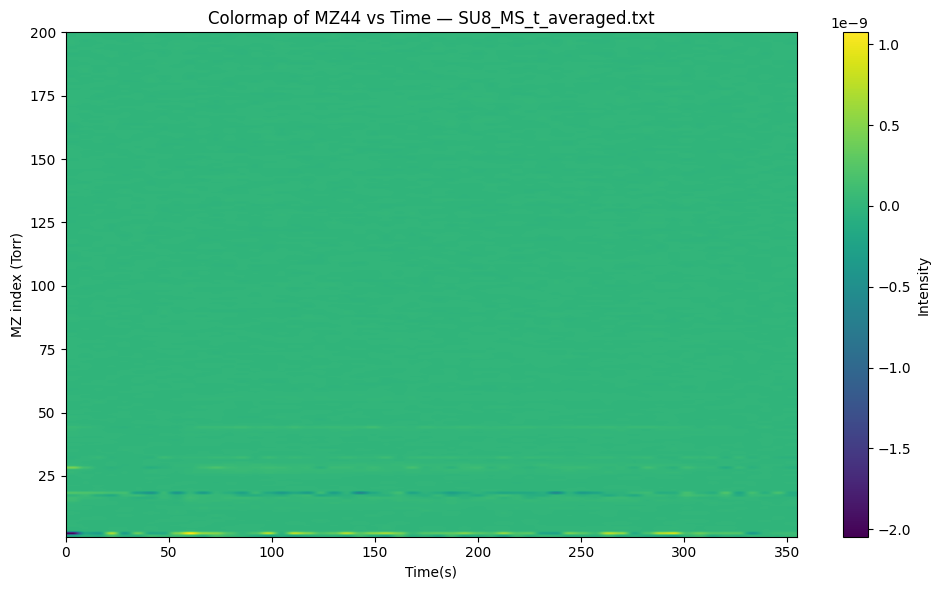

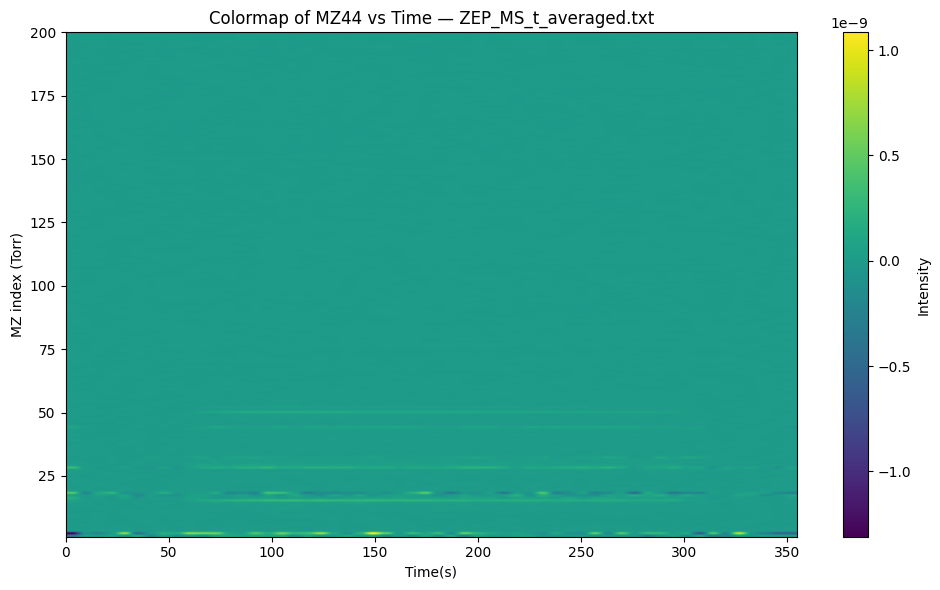

In [19]:
import matplotlib.pyplot as plt
import numpy as np

for df in dfs:
    label = df['source_file'].iloc[0] if 'source_file' in df.columns else 'Unnamed'

    # Extract all MZ{i} columns
    mz_cols = [col for col in df.columns if col.startswith("MZ")]
    mz_indices = [int(col[2:-6]) for col in mz_cols]
    mz_indices_sorted = sorted(mz_indices)

    # Build 2D array: rows = time, columns = MZ{i}
    mz_matrix = np.array([df[f"MZ{i}(Torr)"] for i in mz_indices_sorted])
    time = df['Time(s)'].values
    mz_labels = [f"MZ{i} (Torr)" for i in mz_indices_sorted]

    plt.figure(figsize=(10, 6))
    plt.imshow(
        (mz_matrix),
        aspect='auto',
        extent=[time.min(), time.max(), mz_indices_sorted[0], mz_indices_sorted[-1]],
        origin='lower',
        cmap='viridis'
    )
    plt.colorbar(label='Intensity')
    plt.xlabel("Time(s)")
    plt.ylabel("MZ index (Torr)")
    plt.title(f"Colormap of MZ{i} vs Time — {label}")
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_108895/3661521748.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


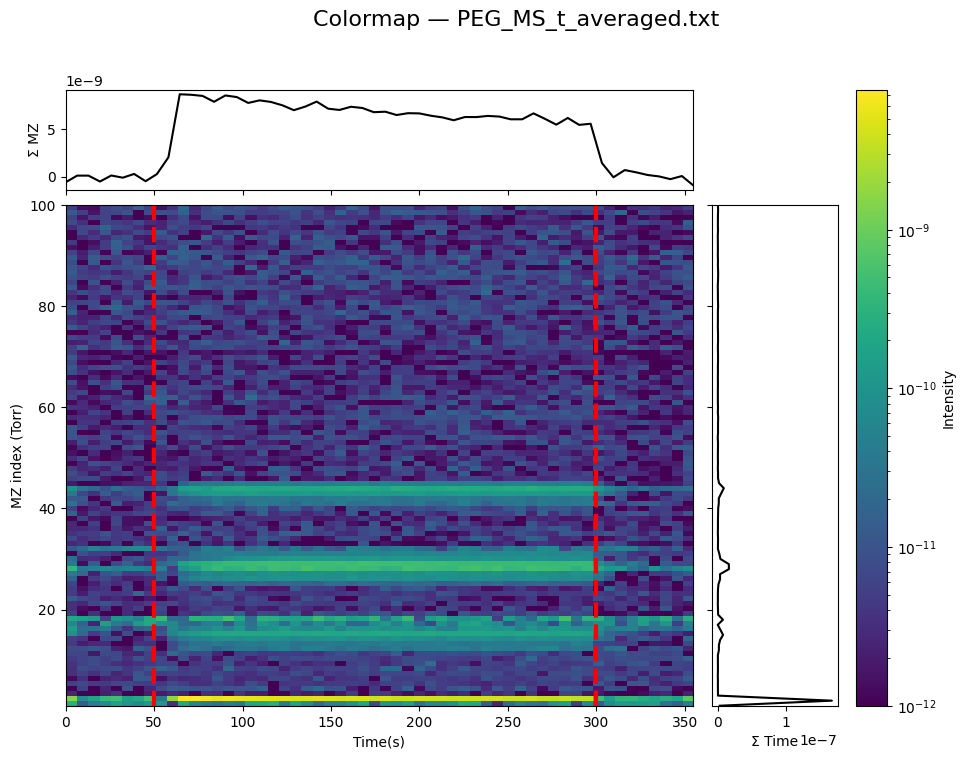

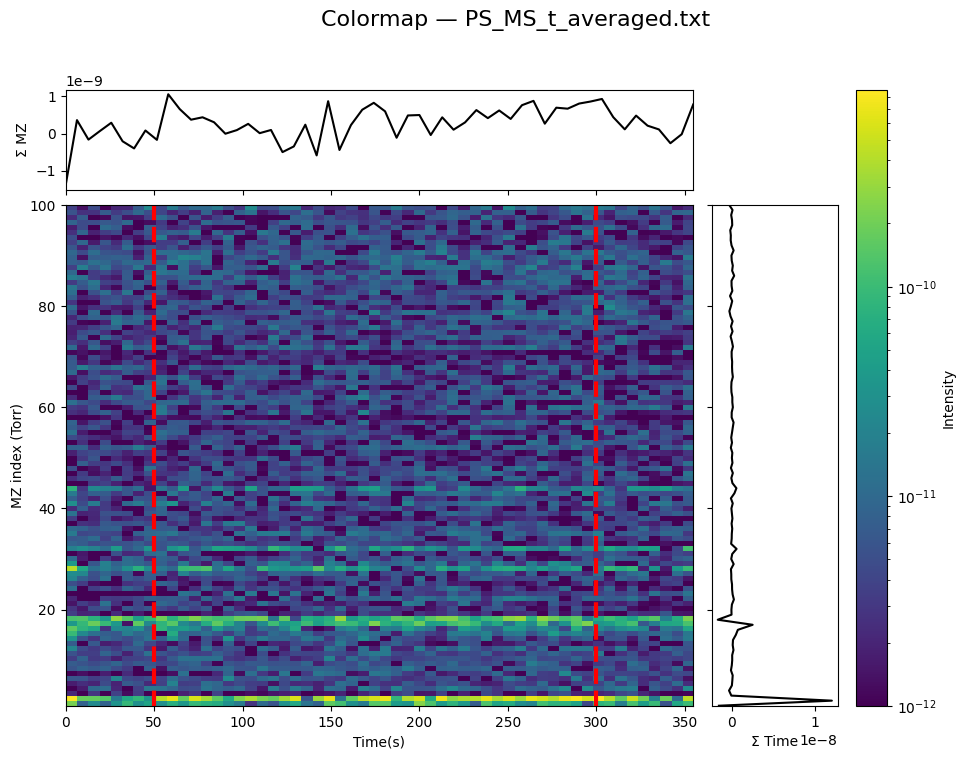

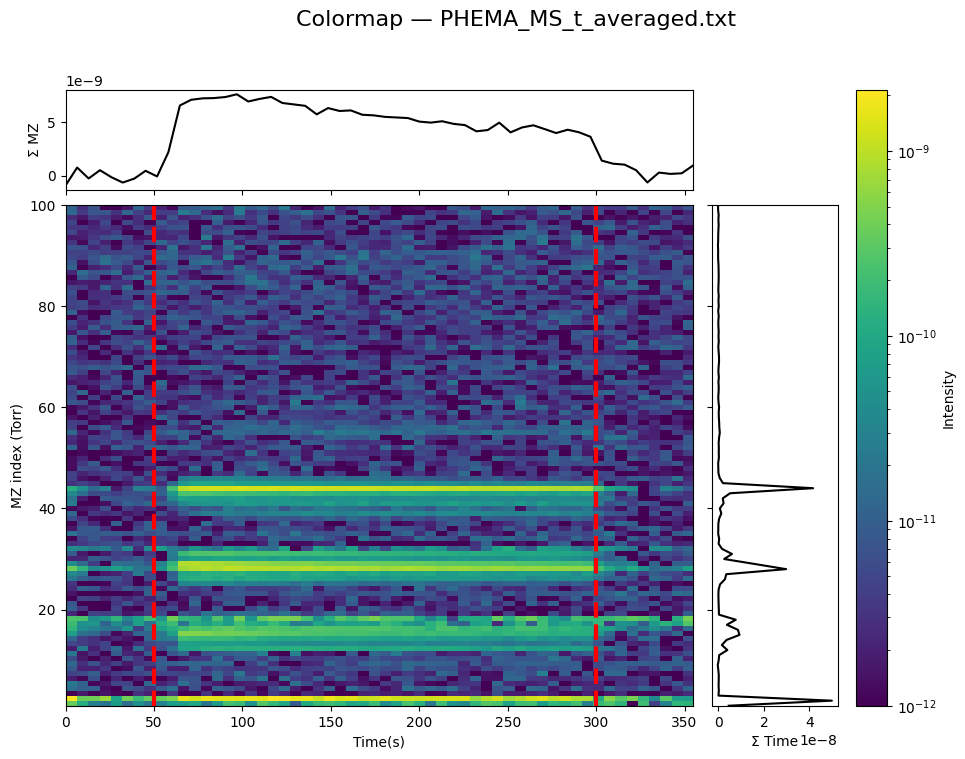

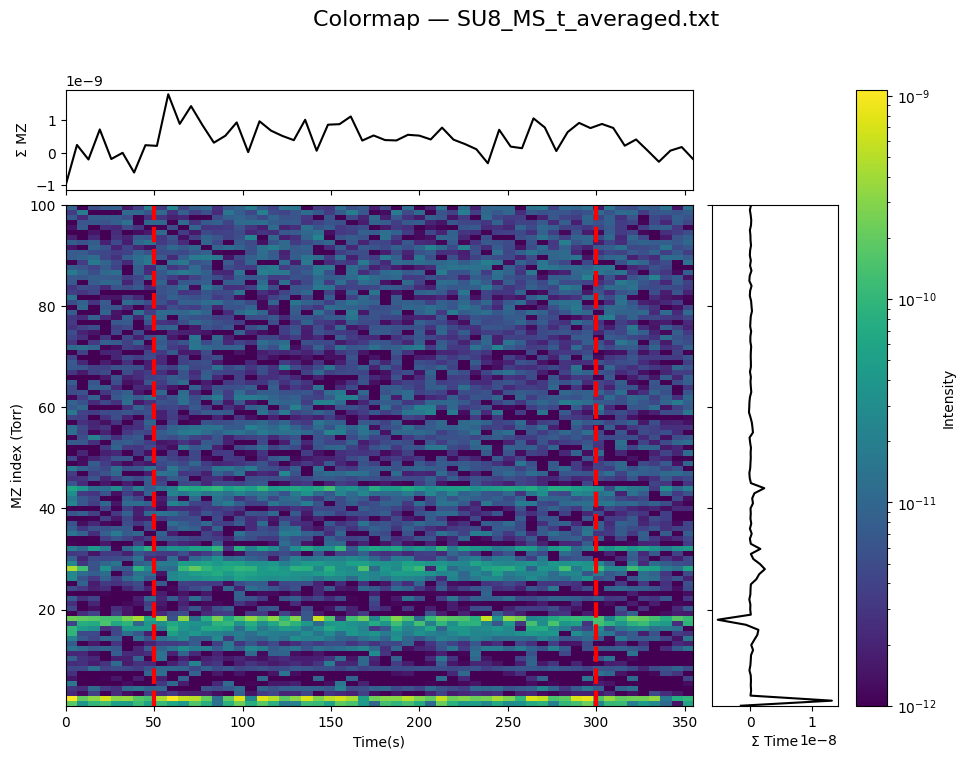

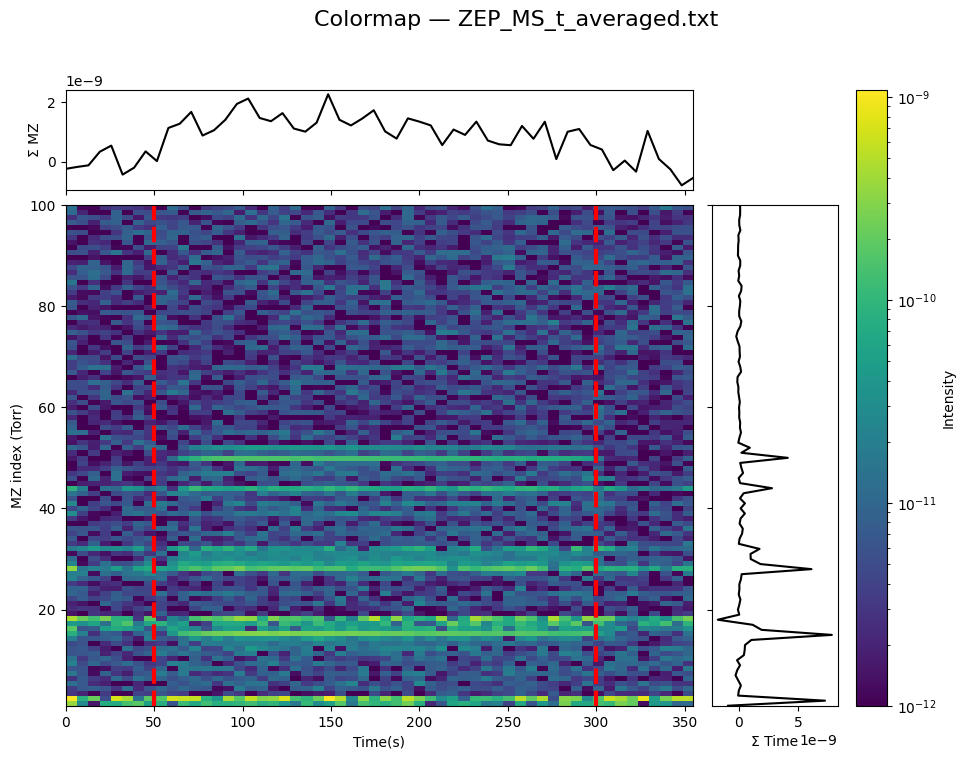

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm


for df in dfs:
    label = df['source_file'].iloc[0] if 'source_file' in df.columns else 'Unnamed'

    # Extract MZ{i} columns and sort
    mz_cols = [col for col in df.columns if col.startswith("MZ")]
    mz_indices = sorted([int(col[2:-6]) for col in mz_cols if 1 <= int(col[2:-6]) <= 100])
    mz_matrix = np.array([df[f"MZ{i}(Torr)"] for i in mz_indices])
    time = df['Time(s)'].values

    # Compute sums
    sum_over_mz = mz_matrix.sum(axis=0)  # shape: (len(time),)
    sum_over_time = mz_matrix.sum(axis=1)  # shape: (len(mz_indices),)

    # Create layout
    fig = plt.figure(figsize=(12, 8))
    gs = GridSpec(2, 2, width_ratios=[5, 1], height_ratios=[1, 5], hspace=0.05, wspace=0.05)

    ax_main = fig.add_subplot(gs[1, 0])
    ax_top = fig.add_subplot(gs[0, 0], sharex=ax_main)
    ax_side = fig.add_subplot(gs[1, 1], sharey=ax_main)

    # Main colormap
    im = ax_main.imshow(
        np.abs(mz_matrix),
        aspect='auto',
        extent=[time.min(), time.max(), mz_indices[0], mz_indices[-1]],
        origin='lower',
        cmap='viridis',
        norm=LogNorm(vmin=max(mz_matrix.min(), 1e-12), vmax=mz_matrix.max())
    )
    ax_main.set_xlabel("Time(s)")
    ax_main.set_ylabel("MZ index (Torr)")
    #ax_main.set_title(f"Colormap — {label}")

    # Add vertical lines
    ax_main.axvline(x=50, color='red', linestyle='--', linewidth=3)
    ax_main.axvline(x=300, color='red', linestyle='--', linewidth=3)


    # Top plot: sum over MZ
    ax_top.plot(time, sum_over_mz, color='black')
    ax_top.set_ylabel("Σ MZ")
    ax_top.tick_params(labelbottom=False)

    # Side plot: sum over time
    ax_side.plot(sum_over_time, mz_indices, color='black')
    ax_side.set_xlabel("Σ Time")
    ax_side.tick_params(labelleft=False)

    # Colorbar
    cbar = fig.colorbar(im, ax=[ax_main, ax_top, ax_side], orientation='vertical', pad=0.02)
    cbar.set_label("Intensity")

    plt.tight_layout()
    #fig.subplots_adjust(top=0.88)  # Add extra space for title
    fig.suptitle(f"Colormap — {label}", fontsize=16)  # Title for entire figure
    plt.show()


/tmp/ipykernel_108895/2877485242.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


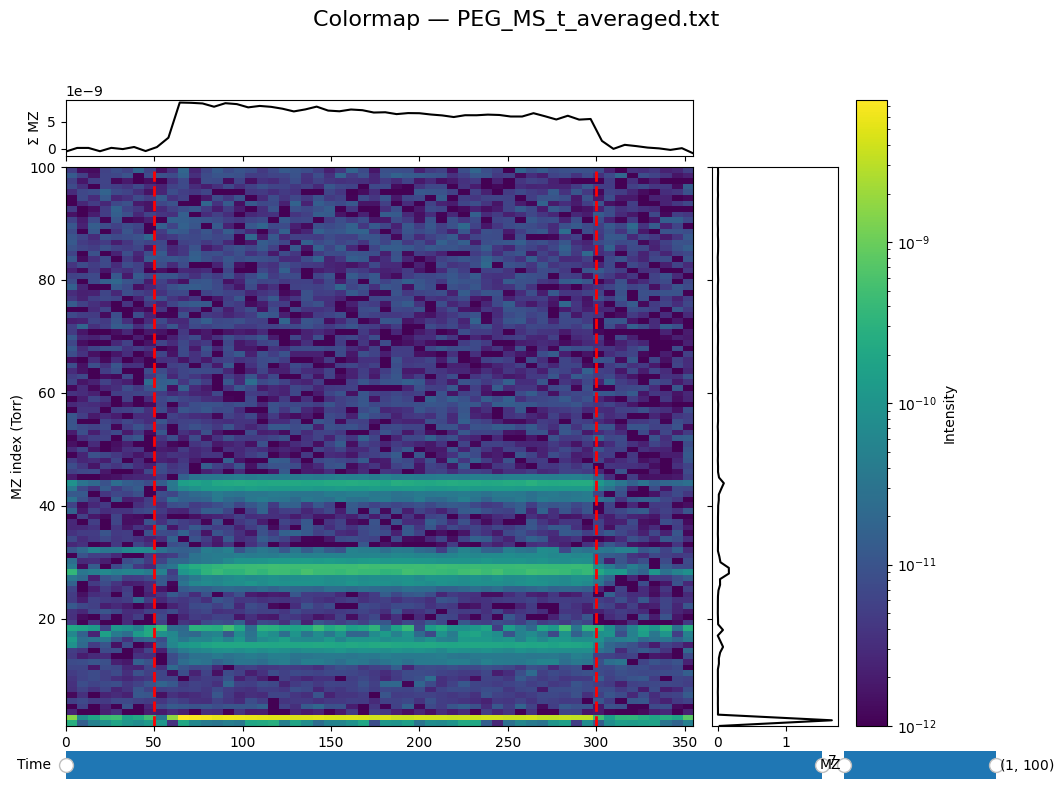

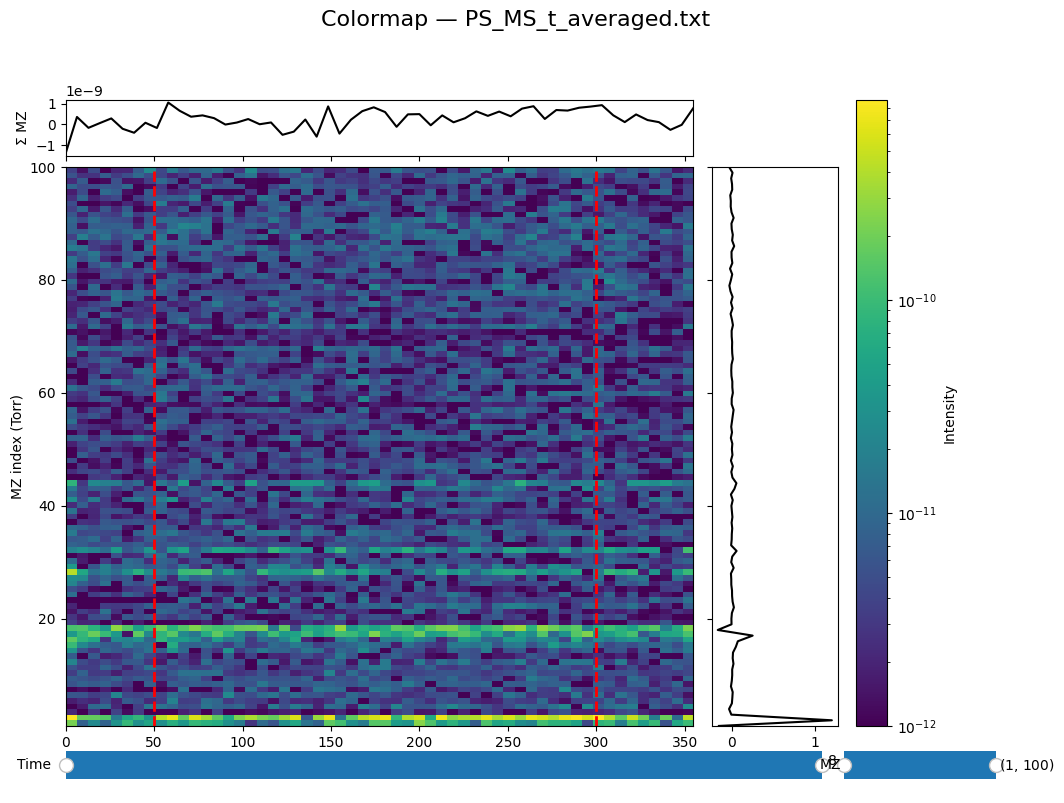

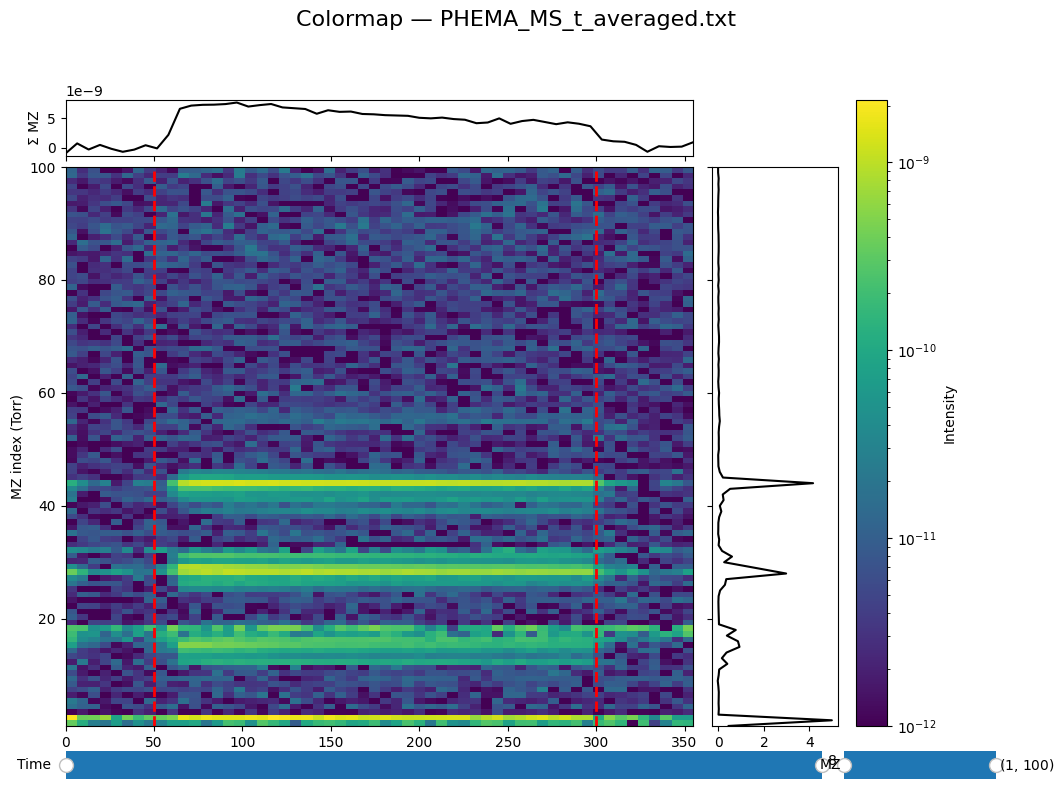

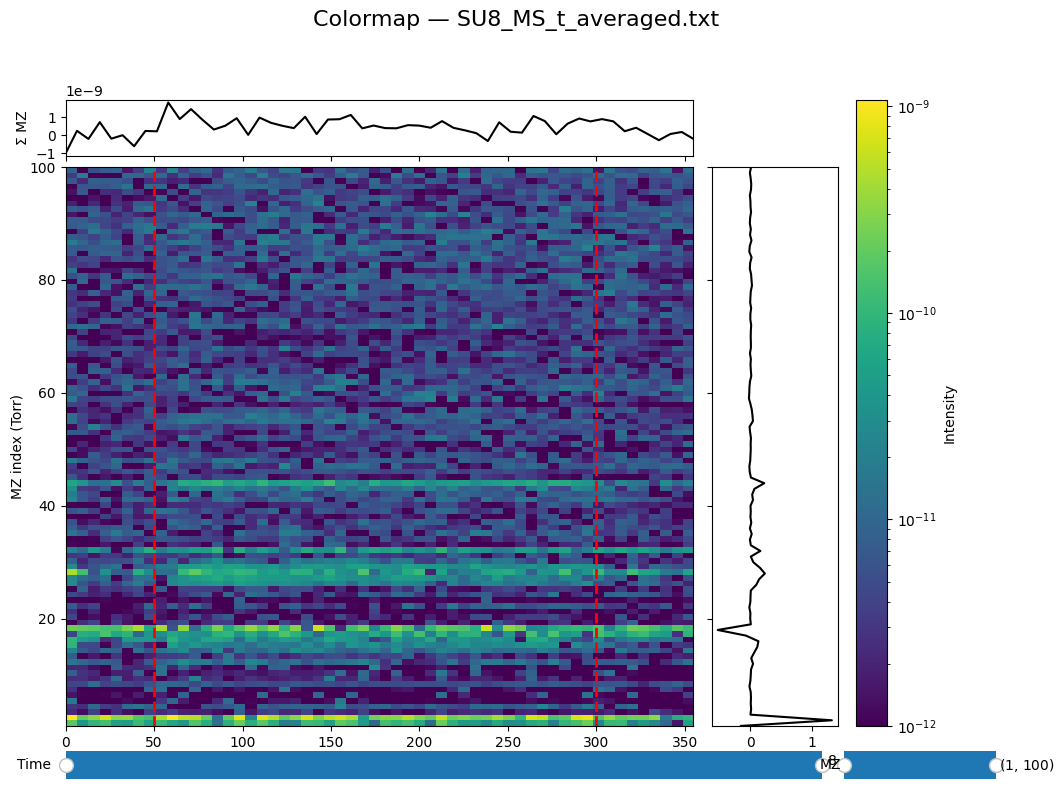

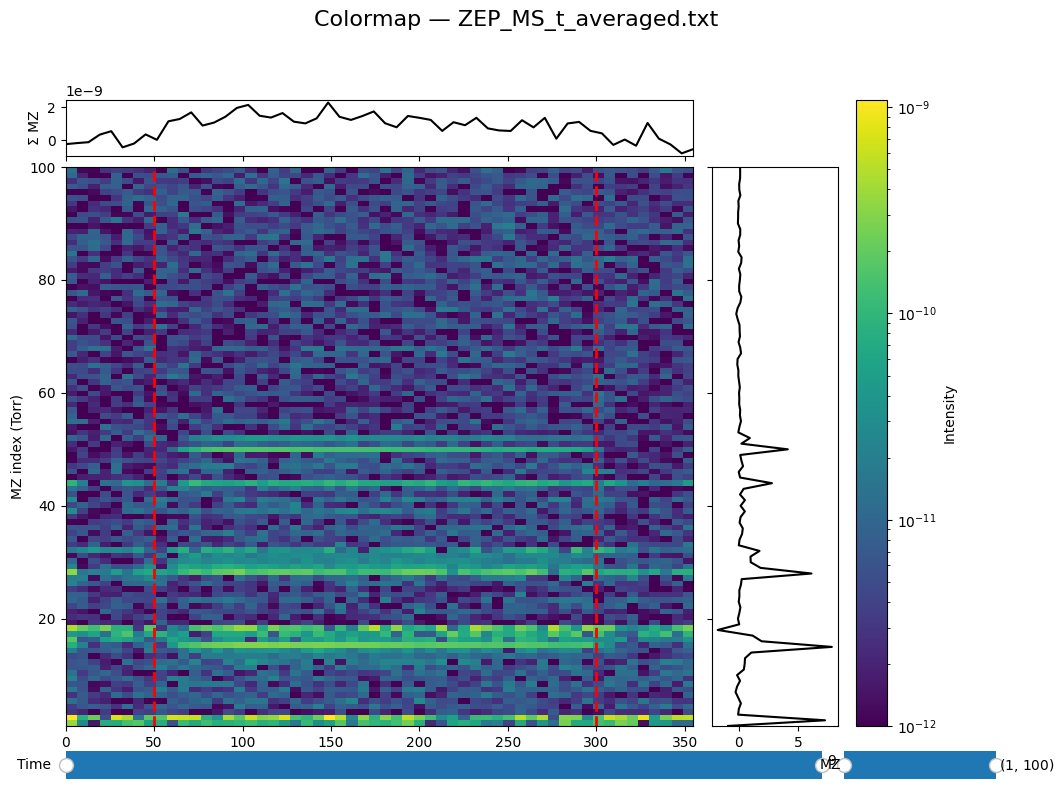

In [38]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
from matplotlib.widgets import RangeSlider

for df in dfs:
    label = df['source_file'].iloc[0] if 'source_file' in df.columns else 'Unnamed'

    mz_cols = [col for col in df.columns if col.startswith("MZ")]
    mz_indices = sorted([int(col[2:-6]) for col in mz_cols if 1 <= int(col[2:-6]) <= 100])
    mz_matrix = np.array([df[f"MZ{i}(Torr)"] for i in mz_indices])
    time = df['Time(s)'].values

    fig = plt.figure(figsize=(12, 9))
    gs = GridSpec(3, 2, width_ratios=[5, 1], height_ratios=[0.5, 5, 0.5], hspace=0.05, wspace=0.05)

    ax_main = fig.add_subplot(gs[1, 0])
    ax_top = fig.add_subplot(gs[0, 0], sharex=ax_main)
    ax_side = fig.add_subplot(gs[1, 1], sharey=ax_main)

    # Initial full-range view
    def update(val):
        t_min, t_max = slider_time.val
        mz_min, mz_max = slider_mz.val

        # Mask time and MZ index ranges
        time_mask = (time >= t_min) & (time <= t_max)
        mz_mask = [(mz_min <= i <= mz_max) for i in mz_indices]
        time_subset = time[time_mask]
        mz_subset = [i for i, m in zip(mz_indices, mz_mask) if m]
        matrix_subset = np.array([df[f"MZ{i}(Torr)"][time_mask] for i in mz_subset])

        ax_main.clear()
        ax_top.clear()
        ax_side.clear()

        im = ax_main.imshow(
            np.abs(matrix_subset),
            aspect='auto',
            extent=[time_subset.min(), time_subset.max(), mz_subset[0], mz_subset[-1]],
            origin='lower',
            cmap='viridis',
            norm=LogNorm(vmin=max(matrix_subset.min(), 1e-12), vmax=matrix_subset.max())
        )
        ax_main.set_xlabel("Time(s)")
        ax_main.set_ylabel("MZ index (Torr)")
        ax_main.axvline(x=50, color='red', linestyle='--', linewidth=2)
        ax_main.axvline(x=300, color='red', linestyle='--', linewidth=2)

        ax_top.plot(time_subset, matrix_subset.sum(axis=0), color='black')
        ax_top.set_ylabel("Σ MZ")
        ax_top.tick_params(labelbottom=False)

        ax_side.plot(matrix_subset.sum(axis=1), mz_subset, color='black')
        ax_side.set_xlabel("Σ Time")
        ax_side.tick_params(labelleft=False)

        fig.suptitle(f"Colormap — {label}", fontsize=16)
        fig.colorbar(im, ax=[ax_main, ax_top, ax_side], orientation='vertical', pad=0.02, label="Intensity")
        fig.canvas.draw_idle()

    # Sliders
    ax_slider_time = fig.add_subplot(gs[2, 0])
    slider_time = RangeSlider(ax_slider_time, "Time", time.min(), time.max(), valinit=(time.min(), time.max()))

    ax_slider_mz = fig.add_subplot(gs[2, 1])
    slider_mz = RangeSlider(ax_slider_mz, "MZ", min(mz_indices), max(mz_indices), valinit=(min(mz_indices), max(mz_indices)))

    slider_time.on_changed(update)
    slider_mz.on_changed(update)

    update(None)  # Initial draw
    plt.tight_layout()
    plt.show()